In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
from descartes import PolygonPatch

import osmnx as ox
import networkx as nx

In [2]:
from metrics import compute_node_closeness, compute_edge_betweenness, compute_edge_sinuosity

In [3]:
# parameters
place_name = 'Gent'  # Zwijndrecht, Gent
buffer_dist = 1000
network_type = 'drive'

# Load

In [4]:
G = ox.graph_from_place(place_name, network_type=network_type, buffer_dist=buffer_dist, retain_all=True)

In [9]:
place = ox.geocode_to_gdf(place_name)

In [6]:
network = ox.utils_graph.graph_to_gdfs(G, nodes=False, edges=True)

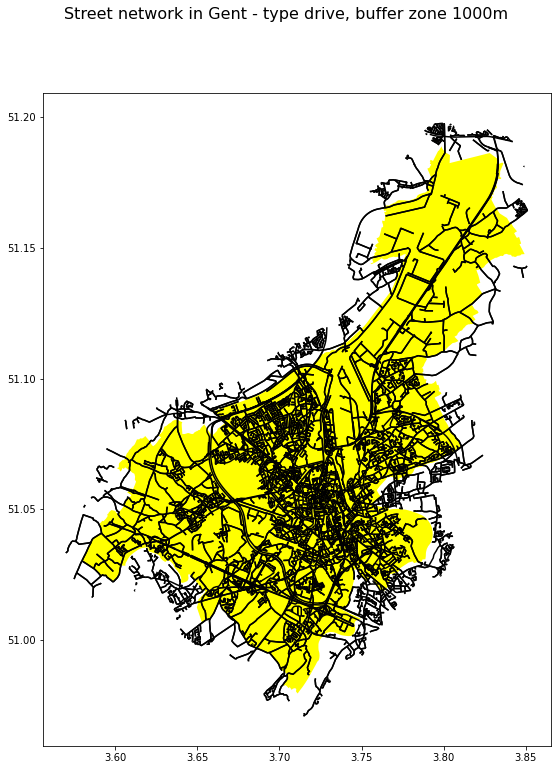

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
fig.suptitle('Street network in {} - type {}, buffer zone {}m'.format(place_name, network_type, buffer_dist), fontsize=16)

network.plot(ax=axs, color='black', zorder=2)
place.plot(ax=axs, color='yellow', linewidth=3, zorder=1)

plt.show()

# Calculate

In [5]:
nodes = compute_node_closeness(G)

Convert to igraph ...
Calculating closeness ...
Convert to dataframe closeness ...


In [6]:
edges = compute_edge_betweenness(G)

Convert to igraph ...
Calculating betweenness ...
Convert to dataframe betweenness ...


In [7]:
edges['edge_sinuosity'] = edges.apply(lambda row: compute_edge_sinuosity(row), axis=1)

In [10]:
edges_clipped = gpd.clip(edges, place)
nodes_clipped = gpd.clip(nodes, place)

# Plot

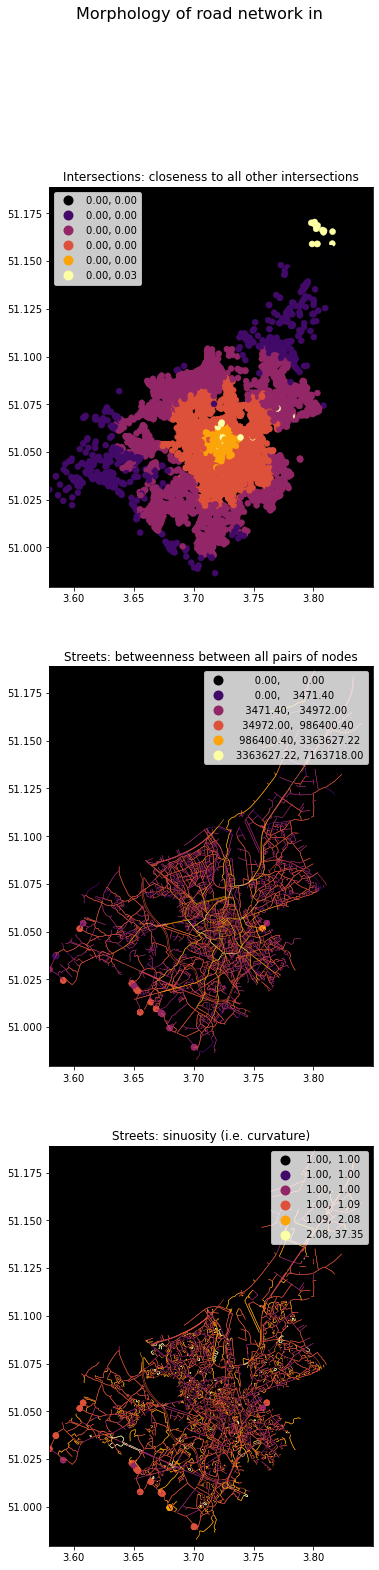

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,25))
fig.suptitle('Morphology of road network in '.format(place_name), fontsize=16)

bbox = place.total_bounds
xlim = ([bbox[0], bbox[2]])
ylim = ([bbox[1], bbox[3]])

nodes_clipped.plot(ax=axs[0], column='node_closeness', cmap='inferno', linewidth=0.5, scheme='percentiles', legend=True)
axs[0].set_title('Intersections: closeness to all other intersections')
axs[0].set_facecolor('black')
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

edges_clipped.plot(ax=axs[1], column='edge_betweenness', cmap='inferno', linewidth=0.5, scheme='percentiles', legend=True)
axs[1].set_title('Streets: betweenness between all pairs of nodes')
axs[1].set_facecolor('black')
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)

edges_clipped.plot(ax=axs[2], column='edge_sinuosity', cmap='inferno', linewidth=0.5, scheme='percentiles', legend=True)
axs[2].set_title('Streets: sinuosity (i.e. curvature)')
axs[2].set_facecolor('black')
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)

plt.show()

# Export

In [18]:
# output_folder = os.path.join('data', 'output')
output_folder = '/data/gent'
# if not os.path.exists(output_folder):
#     os.mkdir(output_folder)

In [19]:
output_file = os.path.join(output_folder, '{}_intersections.csv'.format(place_name.lower()))
nodes.to_csv(output_file)

In [20]:
output_file = os.path.join(output_folder, '{}_streets.csv'.format(place_name.lower()))
edges.to_csv(output_file)